# <div style="text-align: center"> <font size=+5> <ins>PREDICT ANSWERS from INDICATORS</ins> </font> </div>
___


# Imports and settings

In [1]:
#imports 
import numpy as np
import pandas as pd

import os

import ipywidgets as widgets

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression


from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


import tensorflow as tf
import statsmodels as sm
from sklearn.ensemble import GradientBoostingRegressor

from hyperopt import fmin, tpe, hp, Trials, space_eval, STATUS_OK, STATUS_FAIL
from hyperopt.pyll import scope as ho_scope

2024-11-20 18:13:46.691839: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#settings
pd.set_option('display.max_columns', 500)

plt.rcParams.update({'figure.figsize': [6.0, 4.0],
                     'figure.dpi' : 300,
                     'font.size': 12.0, 
                     'mathtext.fontset' : 'stix', 
                     'font.family' : 'STIXGeneral'
                    })

___
# Get datasets

In [30]:
#get dataset
full_dataset = pd.read_pickle("../Saved_variables/full_dataset.pickle")

#convert categorical indicators to numerical
conv_dict_respData = {
        "Sex" : {"Male" : -1, "Female" : 1},
        "Education level" : {"No degree" : 0, "Primary" : 1, "Secondary" : 2, "University" : 3},
        "Living area" : {"Rural area" : 0, "Small city" : 1, "Big city" : 2},
        "Political orientation" : {"Far Left" : -3, "Left" : -2, "Center Left" : -1, "Center" : 0, "None/Other" : 0, "Center Right" : 1, "Right" : 2, "Far Right" : 3},
        "Religious beliefs" : {"Atheist" : 0, "Christian" : 1, "Islamic" : 1, "Jewish" : 1, "Other" : 1}
    }

data_resp_numerical = full_dataset.loc[:, ("Respondent Data", slice(None))].apply(lambda col: col if col.name[1] not in conv_dict_respData else col.map(lambda x: np.nan if pd.isna(x) else conv_dict_respData[col.name[1]][x]).astype(float))
full_dataset = full_dataset.drop(columns=["Respondent Data"])
full_dataset = pd.concat([data_resp_numerical, full_dataset], axis=1)

/var/folders/mv/3xxn6x011nj1xbbrht5z6r1m0000gn/T/ipykernel_9055/2446248056.py:14: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  full_dataset = full_dataset.drop(columns=["Respondent Data"])


___
# TensorFlow multi-level linear model

- Fixed intercept (to start at average answer)
- Fixed slope for country-level predictors
- Slope varies by country for individual-level predictors

In [31]:
# Define inputs

macro_indicators = ["CO2 emissions per capita", "GDP growth", "Gini index", "GDP per capita (Purchasing Power Parity)", "Pesticides use"]
micro_indicators = ['Sex', 'Age', 'Education level', 'Personal income', 'Living area', 'Political orientation', 'Religious beliefs']

In [32]:
# Set up TensorFlow Model

# Extract unique country tags
unique_countries = full_dataset.index.get_level_values("Country").unique().sort_values()


# Define custom layer which uses different kernels for each country
class CustomDenseLayer(tf.keras.layers.Layer):
    def __init__(self, unique_countries, output_dim, **kwargs):
        self.unique_countries = unique_countries
        self.num_countries = len(unique_countries)
        self.output_dim = output_dim
        super().__init__(**kwargs)
    
    def build(self, input_shape):
        # Create a kernel for each country
        self.kernels = {
            country: self.add_weight(
                name=f'kernel_{country}',
                shape=(input_shape[-1], self.output_dim),
                initializer='zeros',
                trainable=True
            ) for country in self.unique_countries
        }
        super().build(input_shape)
    
    def call(self, inputs, country_indices):
        # Apply the appropriate kernel to each input based on the country index
        outputs = []
        for i, country in enumerate(self.unique_countries):
            mask = tf.cast(tf.equal(country_indices, i), tf.float32)
            masked_input = inputs * tf.expand_dims(mask, -1)
            output = tf.matmul(masked_input, self.kernels[country])
            outputs.append(output)
        result = tf.reduce_sum(tf.stack(outputs, axis=0), axis=0)[0]
        return tf.reshape(result, (-1, self.output_dim))

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)


class CustomSumLayer(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        self.bias = self.add_weight(
            name='bias',
            initializer='zeros',
            trainable=True,
            shape=(input_shape[-1])
        )
        super().build(input_shape)

    def call(self, input1, input2):
        return input1 + input2 + self.bias

    def compute_output_shape(self, input_shape):
        return (input_shape[0], 1)

num_macro_ind = len(macro_indicators)
num_micro_ind = len(micro_indicators)

#create blank model (weights initialized to zero)
def new_model_tf():
    input_macro = tf.keras.layers.Input(shape=(num_macro_ind,), name="Macro_data")
    input_micro = tf.keras.layers.Input(shape=(num_micro_ind,), name="Micro_data")
    input_country_indices = tf.keras.layers.Input(shape=(1,), dtype=tf.int32, name="Country_indices")
    
    # Define shared weight layer for macro indicators
    macro_dense_layer = tf.keras.layers.Dense(1, kernel_initializer="zeros", use_bias=False, name="Macro_dense_layer")(input_macro)
    #macro_dense_layer = tf.keras.layers.Dense(1, use_bias=False, name="Macro_dense_layer")(input_macro)
    
    # Define custom weight layer for micro indicators
    custom_dense_layer = CustomDenseLayer(unique_countries, 1, name="Micro_custom_layer")
    micro_custom_layer = custom_dense_layer(input_micro, input_country_indices)
    
    # Define the output layer
    custom_sum_layer = CustomSumLayer(name="Get_prediction")
    output = custom_sum_layer(macro_dense_layer, micro_custom_layer)
    
    # Create the model
    model = tf.keras.models.Model(inputs=[input_macro, input_micro, input_country_indices], outputs=output, name="Model")
    
    # Compile the model
    model.compile(optimizer='adam', loss='mse')

    return model

In [33]:
# Preprocessing data for the model
def preprocess_data_tf(df, year, macro_ind, micro_ind, target):
    # select year
    df = df.loc[year]
    
    # fill missing individual values with country average and macro indicator with year average. Return which countries and indicators are missing for further processing
    # if individual indicator is missing for whole country replace with 0.
    missing_values = df.groupby("Country").mean().map(lambda x: np.isnan(x)) # mark which countries have missing data
    
    df_micro_filled = df.loc[:,("Respondent Data", slice(None))].fillna(df.loc[:,("Respondent Data", slice(None))].groupby("Country").mean()) #fill individual missing data with country average
    df_micro_filled = df_micro_filled.fillna(0) #if whole individual indicator is missing fill with 0 (indicator for country will be marked as true in missing_values dataframe)
    
    df_macro_filled = df.loc[:,("Country-wide indicators", slice(None))].fillna(df.loc[:,("Country-wide indicators", slice(None))].mean()) #fill macro indicator with average
    
    df_filled = pd.concat([df_micro_filled, df_macro_filled, df.loc[:,("Environmental concern dimension", slice(None))]], axis=1).droplevel(level=0, axis=1) #get dataframe

    #train-test split
    df_train, df_test = train_test_split(df_filled, test_size=0.2)
    df_train, df_val = train_test_split(df_train, test_size=0.25)

    #normalization
    scaler = StandardScaler()
    df_train.iloc[:] = scaler.fit_transform(df_train)
    df_val.iloc[:] = scaler.transform(df_val)
    df_test.iloc[:] = scaler.transform(df_test)
    

    #split data into macro and micro indicators
    X_macro_train = df_train.loc[:, macro_ind].values
    X_micro_train = df_train.loc[:, micro_ind].values
    y_train = df_train.loc[:, target].values
    country_indices_train = df_train.index.get_level_values("Country").to_series().map({country: i for i, country in enumerate(unique_countries)}).values
    
    X_macro_val = df_val.loc[:, macro_ind].values
    X_micro_val = df_val.loc[:, micro_ind].values
    y_val = df_val.loc[:, target].values
    country_indices_val = df_val.index.get_level_values("Country").to_series().map({country: i for i, country in enumerate(unique_countries)}).values

    X_macro_test = df_test.loc[:, macro_ind].values
    X_micro_test = df_test.loc[:, micro_ind].values
    y_test = df_test.loc[:, target].values
    country_indices_test = df_test.index.get_level_values("Country").to_series().map({country: i for i, country in enumerate(unique_countries)}).values
    
    
    return [X_macro_train, X_micro_train, country_indices_train], y_train, [X_macro_val, X_micro_val, country_indices_val], y_val,[X_macro_test, X_micro_test, country_indices_test], y_test, missing_values

In [43]:
# Fitting Model

index_micro = pd.MultiIndex.from_product([
    ['Awareness', 'Will to make sacrifices','Efficacy of environmental action'],
    [1993, 2000, 2010, 2020],
    unique_countries],
    names = ["Environmental Concern Dimension", "Year", "Country"]
                                )
index_macro = pd.MultiIndex.from_product([
    ['Awareness', 'Will to make sacrifices', 'Efficacy of environmental action'],
    [1993, 2000, 2010, 2020]],
    names = ["Environmental Concern Dimension", "Year"]
                                )



predictive_indicators_individual_tensorflowModel = pd.DataFrame(index=index_micro, columns=pd.Index(micro_indicators, name="Indicators"))
predictive_indicators_macro_tensorflowModel = pd.DataFrame(index=index_macro, columns=pd.Index(macro_indicators, name="Indicators"))
losses_individual = pd.DataFrame(index = index_micro, columns=pd.Index(["r2", "mae", "mse"], name="Losses"))
losses_macro = pd.DataFrame(index = index_macro, columns=pd.Index(["r2", "mae", "mse"], name="Losses"))
histories_tf = pd.Series(index = index_macro, dtype="object")
models_tf = pd.Series(index=index_macro, dtype="object")

for target in ['Awareness', 'Will to make sacrifices', 'Efficacy of environmental action']:
    for year in [1993, 2000, 2010, 2020]:
        print(f"Training custom TensorFlow model for '{target}' in {year}\n")    
        X_train, y_train, X_val, y_val, X_test, y_test, missing_data = preprocess_data_tf(full_dataset, year, macro_indicators, micro_indicators, target)       
        model = new_model_tf()

        #fit
        earlystop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=False, start_from_epoch=3)
        
        hist = model.fit(X_train, y_train, epochs=50, batch_size=None, verbose=2, callbacks=[earlystop], validation_data=(X_val, y_val))
        histories_tf.loc[(target, year)] = hist
        models_tf.loc[(target, year)] = model

        #get weights
        predictive_indicators_individual_tensorflowModel.loc[(target, year, slice(None)),:] = pd.DataFrame.from_dict(model.get_layer("Micro_custom_layer").kernels).map(lambda x: x.numpy()[0]).T.values
        predictive_indicators_macro_tensorflowModel.loc[(target, year),:] = pd.DataFrame.from_dict(model.get_layer("Macro_dense_layer").weights).map(lambda x: x.numpy()[0]).values

        #get predictions and evaluate model
        y_pred = model.predict(X_test, verbose=0).squeeze()
        r2_loss = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        losses_macro.loc[(target, year),:] = r2_loss, mae, mse


        for i, country in enumerate(unique_countries):
            y_test_country = [y for k,y in enumerate(y_test) if X_test[2][k] == i]
            y_pred_country = [y for k,y in enumerate(y_pred) if X_test[2][k] == i]

            if len(y_test_country) > 0:
                r2_loss = r2_score(y_test_country, y_pred_country)
                mae = mean_absolute_error(y_test_country, y_pred_country)
                mse = mean_squared_error(y_test_country, y_pred_country)
                losses_individual.loc[(target, year, country),:] = r2_loss, mae, mse

        del(hist, r2_loss, mae, mse)
        
        print("\n\n")


predictive_indicators_individual_tensorflowModel = pd.concat([predictive_indicators_individual_tensorflowModel, losses_individual], axis=1, keys=["Indicators", "Loss"])
predictive_indicators_macro_tensorflowModel = pd.concat([predictive_indicators_macro_tensorflowModel, losses_macro.groupby(["Environmental Concern Dimension", "Year"]).mean()], axis=1, keys=["Indicators", "Loss"])

index = [idx in full_dataset.index.droplevel(2) for idx in predictive_indicators_individual_tensorflowModel.index.droplevel(0)]
predictive_indicators_individual_tensorflowModel = predictive_indicators_individual_tensorflowModel.loc[index]

Training custom TensorFlow model for 'Awareness' in 1993

Epoch 1/50
531/531 - 7s - loss: 0.9783 - val_loss: 0.9954 - 7s/epoch - 13ms/step
Epoch 2/50
531/531 - 2s - loss: 0.9683 - val_loss: 0.9920 - 2s/epoch - 3ms/step
Epoch 3/50
531/531 - 2s - loss: 0.9638 - val_loss: 0.9924 - 2s/epoch - 3ms/step
Epoch 4/50
531/531 - 2s - loss: 0.9647 - val_loss: 0.9899 - 2s/epoch - 3ms/step
Epoch 5/50
531/531 - 2s - loss: 0.9636 - val_loss: 0.9919 - 2s/epoch - 3ms/step
Epoch 6/50
531/531 - 2s - loss: 0.9635 - val_loss: 0.9924 - 2s/epoch - 3ms/step



Training custom TensorFlow model for 'Awareness' in 2000

Epoch 1/50
582/582 - 7s - loss: 0.9228 - val_loss: 0.8942 - 7s/epoch - 12ms/step
Epoch 2/50
582/582 - 2s - loss: 0.9053 - val_loss: 0.8901 - 2s/epoch - 3ms/step
Epoch 3/50
582/582 - 2s - loss: 0.9036 - val_loss: 0.8868 - 2s/epoch - 3ms/step
Epoch 4/50
582/582 - 2s - loss: 0.9025 - val_loss: 0.8885 - 2s/epoch - 3ms/step
Epoch 5/50
582/582 - 2s - loss: 0.9023 - val_loss: 0.8911 - 2s/epoch - 3ms/step

In [46]:
#Save data
predictive_indicators_individual_tensorflowModel.to_pickle("../Saved_variables/predictive_indicators_individual_tensorflow.pickle")
predictive_indicators_macro_tensorflowModel.to_pickle("../Saved_variables/predictive_indicators_macro_tensorflow.pickle")

predictive_indicators_tensorflowModel_merged = predictive_indicators_macro_tensorflowModel
predictive_indicators_tensorflowModel_merged.columns = predictive_indicators_tensorflowModel_merged.columns.map(lambda x: ("Invididual Indicators",x[1]) if x[0] == "Indicators" else x)
predictive_indicators_tensorflowModel_merged = pd.concat([predictive_indicators_individual_tensorflowModel.loc[:,["Indicators"]].groupby(["Environmental Concern Dimension","Year"]).mean(),predictive_indicators_tensorflowModel_merged], axis=1)
predictive_indicators_tensorflowModel_merged.columns = predictive_indicators_tensorflowModel_merged.columns.map(lambda x: ("Country-level Indicators",x[1]) if x[0] == "Indicators" else x)


predictive_indicators_tensorflowModel_merged.to_pickle("../Saved_variables/predictive_indicators_merged_tensorflow.pickle")

___

In [3]:
#quick load
predictive_indicators_individual_tensorflowModel = pd.read_pickle("../Saved_variables/predictive_indicators_individual_tensorflow.pickle")
predictive_indicators_macro_tensorflowModel = pd.read_pickle("../Saved_variables/predictive_indicators_macro_tensorflow.pickle")

___
### Show metrics during training (needs running training, no quick load)

In [52]:
dimension = "Efficacy of environmental action"
year = 2000

Text(0, 0.5, 'Loss')

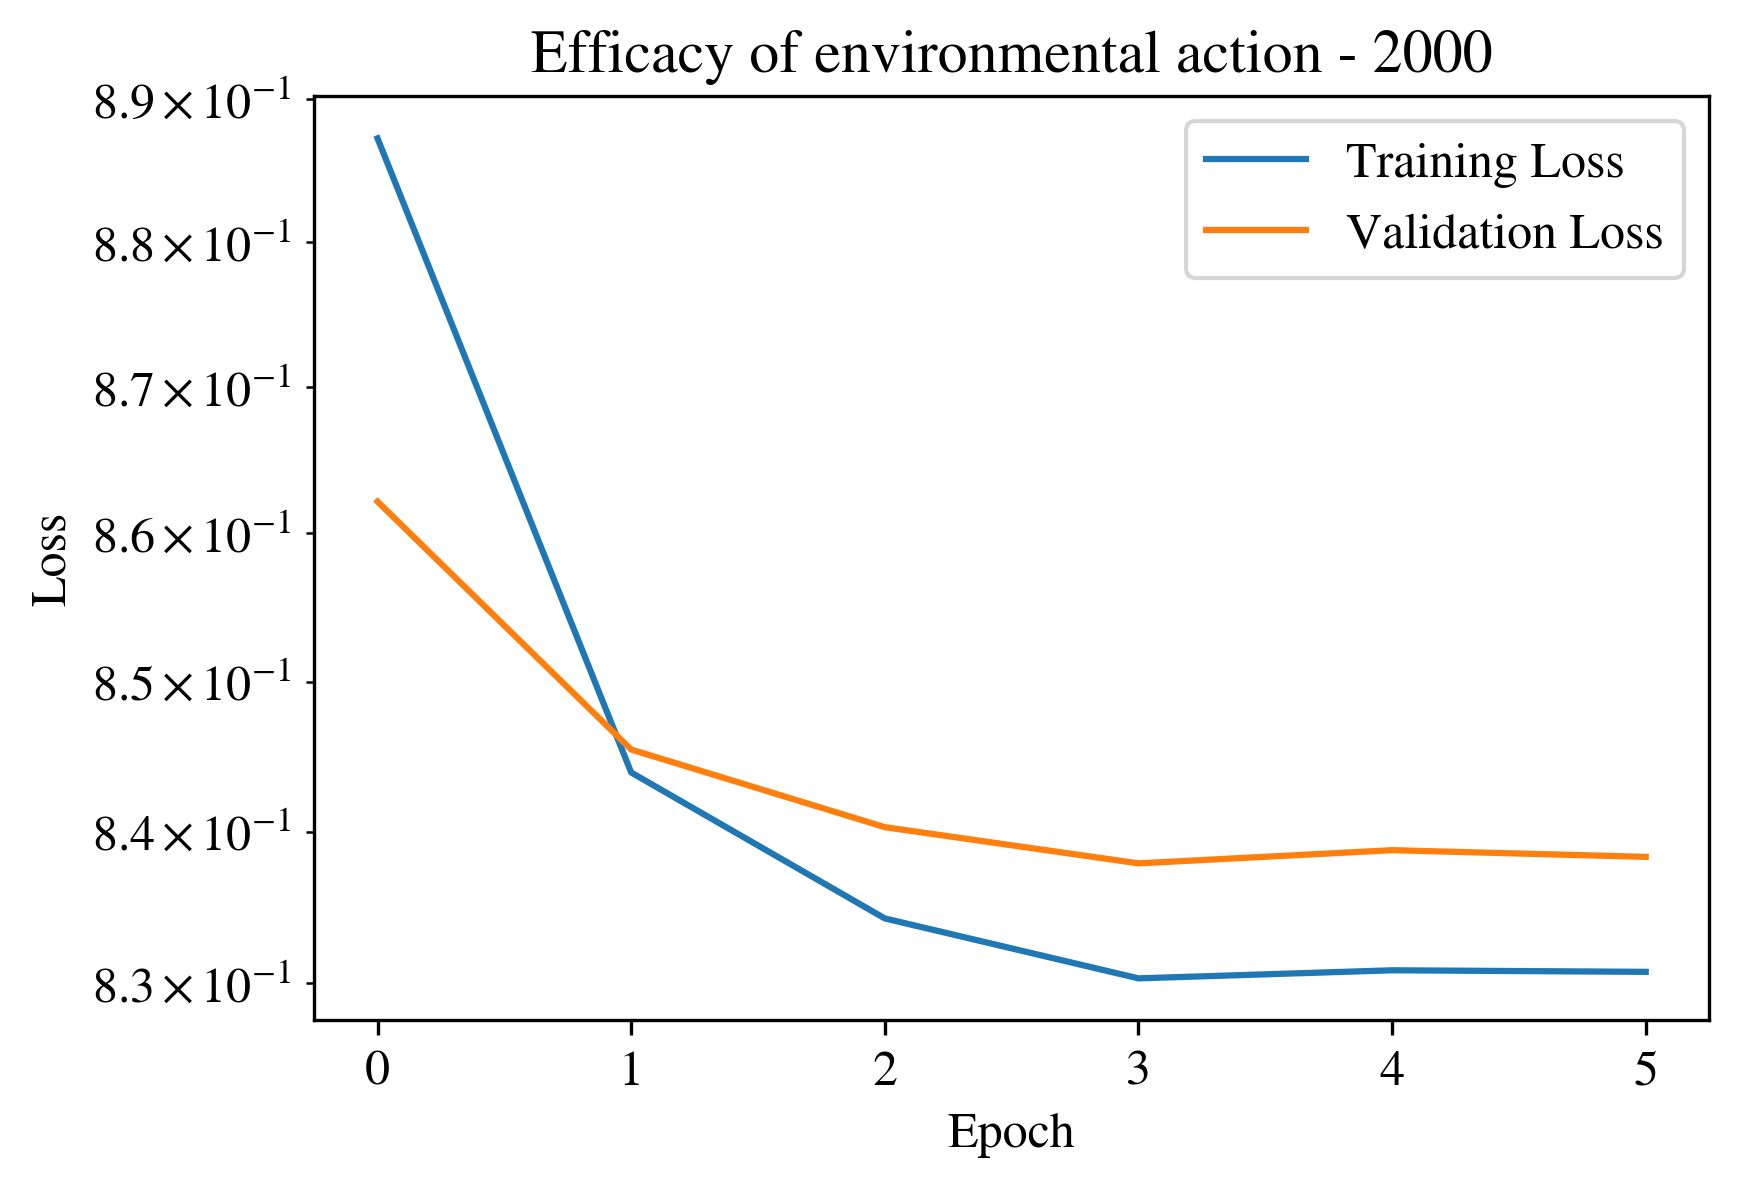

In [53]:
losses = histories_tf.loc[(dimension, year)].history
fig, ax = plt.subplots()
sns.lineplot(losses["loss"], label="Training Loss", ax=ax)
sns.lineplot(losses["val_loss"], label="Validation Loss", ax=ax)
ax.set_yscale("log")
ax.set_title(f"{dimension} - {year}")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

___
### Show predictions (needs running training, no quick load)

In [ ]:
dimension = "Awareness"
year = 2020

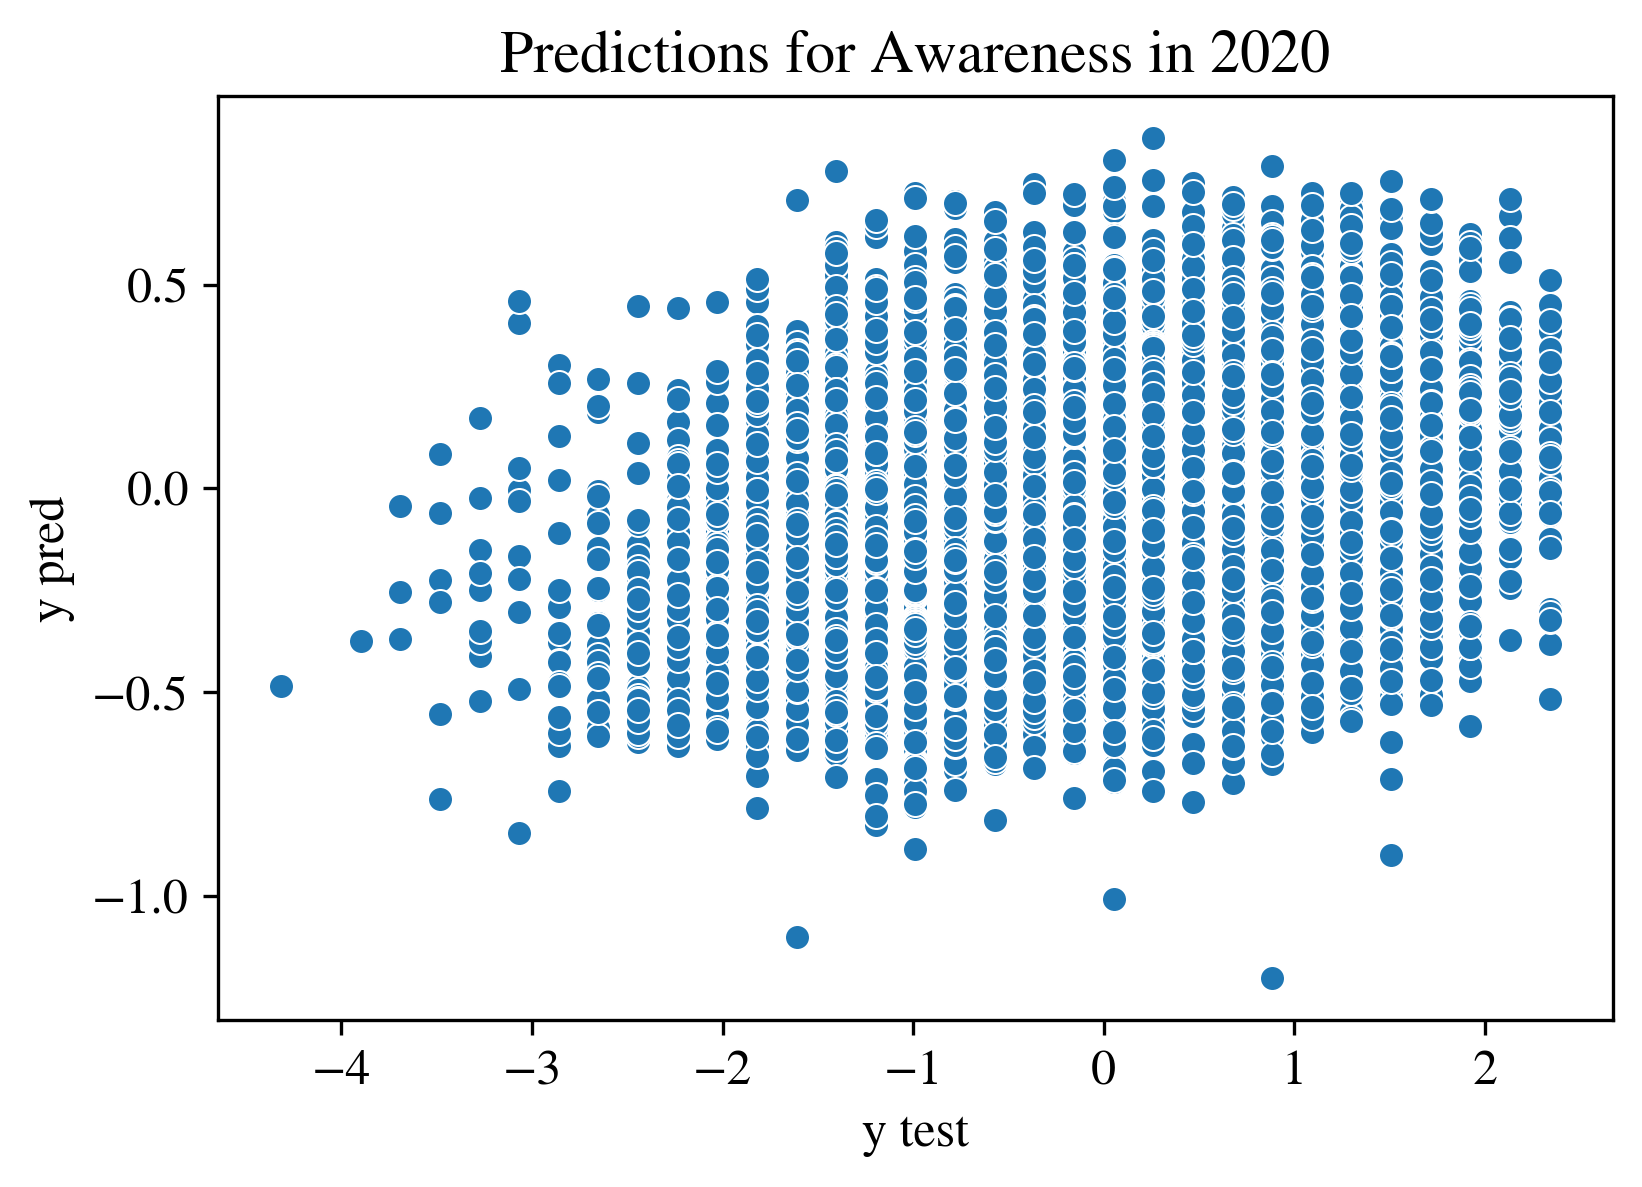

In [ ]:
model = models_tf.loc[(dimension, year)]
_, _, _, _, X_test, y_test, _ = preprocess_data_tf(full_dataset, year, macro_indicators, micro_indicators, dimension)

y_pred = model.predict(X_test, verbose=0).squeeze()

fig, ax = plt.subplots()

sns.scatterplot(x=y_test, y=y_pred, ax=ax)
ax.set_xlabel("y test")
ax.set_ylabel("y pred")
ax.set_title(f"Predictions for {dimension} in {year}");

___
## Plot results

In [54]:
def cluster_dataframe(data, method="single", row_cluster=True, col_cluster=True):
    from scipy.cluster.hierarchy import linkage, dendrogram

    if row_cluster:
        row_linkage = linkage(data, method=method, optimal_ordering=True)
        row_order = dendrogram(row_linkage, no_plot=True)['leaves']
    else:
        row_order = slice(None)

    if col_cluster:
        col_linkage = linkage(data.T, method=method,  optimal_ordering=True)
        col_order = dendrogram(col_linkage, no_plot=True)['leaves']

    else:
        col_order = slice(None)
        
    abs_max = data.abs().max(axis=None)
    
    return data.iloc[row_order, col_order]

def style_dataframe(data):
    max = data.loc[:,"Indicators"].abs().max(axis=None)
    styled_df = data.style.background_gradient(cmap="bwr", axis=None, vmin=-max, vmax=max, subset="Indicators")
    
    cm = sns.light_palette("green", reverse=True, as_cmap=True)
    max = data.loc[:,("Loss", "r2")].max(axis=None)
    min = data.loc[:,("Loss", "r2")].min(axis=None)
    styled_df = styled_df.background_gradient(cmap=cm, subset=[("Loss", "r2")], vmin=min, vmax=max)

    cm = sns.light_palette("green", reverse=False, as_cmap=True)
    max = data.loc[:,("Loss", "mae")].max(axis=None)
    min = data.loc[:,("Loss", "mae")].min(axis=None)
    styled_df = styled_df.background_gradient(cmap=cm, subset=[("Loss", "mae")], vmin=min, vmax=max)

    cm = sns.light_palette("green", reverse=False, as_cmap=True)
    max = data.loc[:,("Loss", "mse")].max(axis=None)
    min = data.loc[:,("Loss", "mse")].min(axis=None)
    styled_df = styled_df.background_gradient(cmap=cm, subset=[("Loss", "mse")], vmin=min, vmax=max)

    
    #display(styled_df)
    return styled_df


def style_dataframe_tensorflow(data):

    try:
        max = data.loc[:,["Individual indicators", "Country-level indicators"]].abs().max(axis=None)
    except:
        try:
            max = data.loc[:,["Individual indicators"]].abs().max(axis=None)
        except:
            pass
        try:
            max = data.loc[:,["Country-level indicators"]].abs().max(axis=None)
        except:
            pass

    styled_df = data.style
    
    if "Individual indicators" in data.columns.get_level_values(0):
        styled_df = styled_df.background_gradient(cmap="bwr", axis=None, vmin=-max, vmax=max, subset=["Individual indicators"])
    if "Country-level indicators" in data.columns.get_level_values(0):
        styled_df = styled_df.background_gradient(cmap="bwr", axis=None, vmin=-max, vmax=max, subset=["Country-level indicators"])
    
    cm = sns.light_palette("green", reverse=True, as_cmap=True)
    max = data.loc[:,("Metrics", "r2")].max(axis=None)
    min = data.loc[:,("Metrics", "r2")].min(axis=None)
    styled_df = styled_df.background_gradient(cmap=cm, subset=[("Metrics", "r2")], vmin=min, vmax=max)

    cm = sns.light_palette("green", reverse=False, as_cmap=True)
    max = data.loc[:,("Metrics", "mse")].max(axis=None)
    min = data.loc[:,("Metrics", "mse")].min(axis=None)
    styled_df = styled_df.background_gradient(cmap=cm, subset=[("Metrics", "mse")], vmin=min, vmax=max)

    cm = sns.light_palette("green", reverse=False, as_cmap=True)
    max = data.loc[:,("Metrics", "mae")].max(axis=None)
    min = data.loc[:,("Metrics", "mae")].min(axis=None)
    styled_df = styled_df.background_gradient(cmap=cm, subset=[("Metrics", "mae")], vmin=min, vmax=max)
    
    return styled_df

In [56]:
data_countrywide = predictive_indicators_macro_tensorflowModel.loc[:,"Indicators"]
data_indiv = predictive_indicators_individual_tensorflowModel.loc[:,"Indicators"].groupby(["Environmental Concern Dimension", "Year"]).mean()
data_metrics = predictive_indicators_macro_tensorflowModel.loc[:,"Loss"]
data = pd.concat([data_countrywide, data_indiv, data_metrics], keys=["Country-level indicators", "Individual indicators", "Metrics"], axis=1)
del(data_countrywide, data_indiv, data_metrics)

data1 = cluster_dataframe(data.loc[:, ("Country-level indicators", slice(None))], row_cluster=False)
data2 = cluster_dataframe(data.loc[:, ("Individual indicators", slice(None))], row_cluster=False)

#what do you want to plot?
#all
cols = [*data1.columns, *data2.columns, *data.loc[:,["Metrics"]].columns[[0,2,1]]]
#country-level only
#cols = [*data1.columns, *data.loc[:,["Metrics"]].columns[[0,2,1]]]
#individual only
#cols = [*data2.columns, *data.loc[:,["Metrics"]].columns[[0,2,1]]]

#print(style_dataframe_tensorflow(data.loc[:,cols]).to_latex(convert_css=True).replace("\color[HTML]{000000}",""))

style_dataframe_tensorflow(data.loc[:,cols])

#### Individual indicators detail

In [47]:
#select specific country
#data = predictive_indicators_individual_tensorflowModel.query("Country == 'United States'")

#select topic and year
#data = predictive_indicators_individual_tensorflowModel.loc[("Awareness",1993,slice(None)),:]

#all data
data = predictive_indicators_individual_tensorflowModel

cluster_rows = False
cluster_columns = True

data_clustered = cluster_dataframe(data.fillna(0).loc[:, ("Indicators", slice(None))], row_cluster=cluster_rows, col_cluster=cluster_columns)
cols = [*data_clustered.columns, *data.loc[:,("Loss", slice(None))].columns]
rows = data_clustered.index

#print(style_dataframe(data.loc[rows,cols]).to_latex(convert_css=True).replace("\color[HTML]{000000}",""))

style_dataframe(data.loc[rows,cols])

/var/folders/mv/3xxn6x011nj1xbbrht5z6r1m0000gn/T/ipykernel_7737/339268833.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_clustered = cluster_dataframe(data.fillna(0).loc[:, ("Indicators", slice(None))], row_cluster=cluster_rows, col_cluster=cluster_columns)


___
# StatsModel Multi-Level linear model

In [24]:
macro_indicators = ["GDP growth", "Gini index", "GDP per capita (Purchasing Power Parity)", "Pesticides use", "CO2 emissions per capita"]
micro_indicators = ['Sex', 'Age', 'Education level', 'Personal income', 'Living area', 'Political orientation', 'Religious beliefs']

In [25]:
# Preprocessing data
def preprocess_data_mixedLM(df, year, macro_ind, micro_ind, target):
    # select year
    df = df.loc[year]
    
    # fill missing individual values with country average and macro indicator with year average. Return which countries and indicators are missing for further processing
    # if individual indicator is missing for whole country replace with 0.
    missing_values = df.groupby("Country").mean().map(lambda x: np.isnan(x)) # mark which countries have missing data
    
    df_micro_filled = df.loc[:,("Respondent Data", slice(None))].fillna(df.loc[:,("Respondent Data", slice(None))].groupby("Country").mean()) #fill individual missing data with country average
    df_micro_filled = df_micro_filled.fillna(0) #if whole individual indicator is missing fill with 0 (indicator for country will be marked as true in missing_values dataframe)
    
    df_macro_filled = df.loc[:,("Country-wide indicators", slice(None))].fillna(df.loc[:,("Country-wide indicators", slice(None))].mean()) #fill macro indicator with average
    
    df_filled = pd.concat([df_micro_filled, df_macro_filled, df.loc[:,("Environmental concern dimension", slice(None))]], axis=1) #get dataframe

    #select features
    df_filled = df_filled.loc[:,df_filled.columns.get_level_values("Variable Name").isin(macro_ind+micro_ind+[target])]
    
    #train-test split
    df_train, df_test = train_test_split(df_filled, test_size=0.2)    

    #normalization
    scaler = StandardScaler()
    df_train.iloc[:] = scaler.fit_transform(df_train)
    df_test.iloc[:] = scaler.transform(df_test)

    #set up country column for mixed model class
    df_train[("Class", "Country")] = df_train.index.get_level_values("Country")
    df_train = df_train.reset_index(drop=True)

    df_test[("Class", "Country")] = df_test.index.get_level_values("Country")
    df_test = df_test.reset_index(drop=True)

    #drop columns label
    df_train.columns = df_train.columns.droplevel("Variable Type")
    df_test.columns = df_test.columns.droplevel("Variable Type")
    
    return df_train, df_test

In [68]:
# Fitting models and getting parameters and metrics

import statsmodels.formula.api as smf

index_mixedLM = pd.MultiIndex.from_product([
    ['Awareness', 'Will to make sacrifices', 'Efficacy of environmental action'],
    [1993, 2000, 2010, 2020]],
    names = ["Environmental Concern Dimension", "Year"]
                                )
predictive_indicators_mixedLM = pd.DataFrame(index=index_mixedLM, columns = pd.Index(macro_indicators+micro_indicators, name="Indicators"))
metrics_mixedLM = pd.DataFrame(index=index_mixedLM, columns = pd.Index(["r2", "mse", "mae", "Residual variance", "ICC", "Converged"], name="Metrics"))

cols_renamed_dict = {ind: ind.replace(" ", "_") for ind in macro_indicators+micro_indicators+['Awareness', 'Will to make sacrifices', 'Efficacy of environmental action']}
cols_renamed_dict.update({"GDP per capita (Purchasing Power Parity)" : "GDP_per_capita_PPP"})    

for target in ['Awareness', 'Will to make sacrifices', 'Efficacy of environmental action']:
    for year in [1993, 2000, 2010, 2020]:
        print(f"Training mixed-effects linear model for '{target}' in {year}\n")    
        data_train, data_test = preprocess_data_mixedLM(full_dataset, year, macro_indicators, micro_indicators, target)

        #rename columns (no spaces or parenthesis)
        data_train.columns = data_train.columns.map(lambda x: cols_renamed_dict.get(x,x))
        data_test.columns = data_test.columns.map(lambda x: cols_renamed_dict.get(x,x))
        
        macro_indicators_ = [cols_renamed_dict[ind] for ind in macro_indicators]
        micro_indicators_ = [cols_renamed_dict[ind] for ind in micro_indicators]
        target_ = cols_renamed_dict[target]
        
        # Fit the random effect model
        model = smf.mixedlm(
            f"{target_} ~ {' + '.join(macro_indicators_)} + {' + '.join(micro_indicators_)}",
            data_train, 
            groups=data_train["Country"], 
            re_formula=f"1 + {' + '.join(micro_indicators_)}"
        )
        
        result = model.fit()
    
        #get parameters
        params = result.fe_params.drop("Intercept")
        params.index = params.index.map({k:i for i,k in cols_renamed_dict.items()})
    
        #get metrics
        res_var = result.scale
        intra_class_var = result.cov_re.values.diagonal().sum()
        icc = intra_class_var / (intra_class_var + res_var)

        
        y_pred = result.fittedvalues
        y_true = data_train[target_]
        
        r2_loss = r2_score(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
    
        #save params+metrics
        predictive_indicators_mixedLM.loc[(target, year),:] = params
        if result.converged:
            metrics_mixedLM.loc[(target, year),:] = [r2_loss, mse, mae, res_var, icc, True]
        else:
            metrics_mixedLM.loc[(target, year),:] = [r2_loss, mse, mae, res_var, icc, False]
        
    
        del(model, result, params, res_var, intra_class_var, icc, r2_loss, mse, mae)
        
predictive_indicators_mixedLM = pd.concat([predictive_indicators_mixedLM, metrics_mixedLM], axis=1, keys=["Indicators", "Metrics"])

newLabels = {("Indicators", item) : ("Individual indicators", item) for item in micro_indicators}
newLabels.update({("Indicators", item) : ("Country-level indicators", item) for item in macro_indicators})
predictive_indicators_mixedLM.columns = predictive_indicators_mixedLM.columns.map(lambda x: newLabels.get(x,x))
del(newLabels)

del(metrics_mixedLM)

Training mixed-effects linear model for 'Awareness' in 1993



/Users/Edoardo/anaconda3/envs/tesi/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Edoardo/anaconda3/envs/tesi/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/Edoardo/anaconda3/envs/tesi/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 146.846836
  warnings.warn(msg, ConvergenceWarning)
/Users/Edoardo/anaconda3/envs/tesi/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/Edoardo/anaconda3/envs/tesi/lib/python3.11/sit

Training mixed-effects linear model for 'Awareness' in 2000



/Users/Edoardo/anaconda3/envs/tesi/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Edoardo/anaconda3/envs/tesi/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/Edoardo/anaconda3/envs/tesi/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 274.432554
  warnings.warn(msg, ConvergenceWarning)
/Users/Edoardo/anaconda3/envs/tesi/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


Training mixed-effects linear model for 'Awareness' in 2010



/Users/Edoardo/anaconda3/envs/tesi/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Training mixed-effects linear model for 'Awareness' in 2020



/Users/Edoardo/anaconda3/envs/tesi/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Training mixed-effects linear model for 'Will to make sacrifices' in 1993



/Users/Edoardo/anaconda3/envs/tesi/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Edoardo/anaconda3/envs/tesi/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/Edoardo/anaconda3/envs/tesi/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 227.133182
  warnings.warn(msg, ConvergenceWarning)
/Users/Edoardo/anaconda3/envs/tesi/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/Edoardo/anaconda3/envs/tesi/lib/python3.11/sit

Training mixed-effects linear model for 'Will to make sacrifices' in 2000



/Users/Edoardo/anaconda3/envs/tesi/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Edoardo/anaconda3/envs/tesi/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/Edoardo/anaconda3/envs/tesi/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 219.279718
  warnings.warn(msg, ConvergenceWarning)
/Users/Edoardo/anaconda3/envs/tesi/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Training mixed-effects linear model for 'Will to make sacrifices' in 2010



/Users/Edoardo/anaconda3/envs/tesi/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Training mixed-effects linear model for 'Will to make sacrifices' in 2020



/Users/Edoardo/anaconda3/envs/tesi/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Training mixed-effects linear model for 'Efficacy of environmental action' in 1993



/Users/Edoardo/anaconda3/envs/tesi/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/Edoardo/anaconda3/envs/tesi/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


Training mixed-effects linear model for 'Efficacy of environmental action' in 2000



/Users/Edoardo/anaconda3/envs/tesi/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Edoardo/anaconda3/envs/tesi/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/Edoardo/anaconda3/envs/tesi/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 165.204203
  warnings.warn(msg, ConvergenceWarning)
/Users/Edoardo/anaconda3/envs/tesi/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Training mixed-effects linear model for 'Efficacy of environmental action' in 2010



/Users/Edoardo/anaconda3/envs/tesi/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Training mixed-effects linear model for 'Efficacy of environmental action' in 2020



/Users/Edoardo/anaconda3/envs/tesi/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [69]:
#save data
predictive_indicators_mixedLM.to_pickle("../Saved_variables/predictive_indicators_mixedLM.pickle")

___

In [26]:
# quick load
predictive_indicators_mixedLM = pd.read_pickle("../Saved_variables/predictive_indicators_mixedLM.pickle")

___
## Plot results

In [39]:
def cluster_dataframe(data, method="single", row_cluster=True, col_cluster=True):
    from scipy.cluster.hierarchy import linkage, dendrogram

    if row_cluster:
        row_linkage = linkage(data, method=method, optimal_ordering=True)
        row_order = dendrogram(row_linkage, no_plot=True)['leaves']
    else:
        row_order = slice(None)

    if col_cluster:
        col_linkage = linkage(data.T, method=method,  optimal_ordering=True)
        col_order = dendrogram(col_linkage, no_plot=True)['leaves']

    else:
        col_order = slice(None)
    
    return data.iloc[row_order, col_order]

def style_dataframe_mixedLM(data, dropConverged=False):

    if dropConverged == False:
        #convert convergence column
        data.loc[:,("Metrics", "Converged")] = data.loc[:,("Metrics", "Converged")].map(lambda x: "$\checkmark$" if x else r"$\times$")
    else:
        data = data.drop(columns=[("Metrics", "Converged")])
    
    try:
        max = data.loc[:,["Individual indicators", "Country-level indicators"]].abs().max(axis=None)
    except:
        try:
            max = data.loc[:,["Individual indicators"]].abs().max(axis=None)
        except:
            pass
        try:
            max = data.loc[:,["Country-level indicators"]].abs().max(axis=None)
        except:
            pass

    styled_df = data.style
    
    if "Individual indicators" in data.columns.get_level_values(0):
        styled_df = styled_df.background_gradient(cmap="bwr", axis=None, vmin=-max, vmax=max, subset=["Individual indicators"])
    if "Country-level indicators" in data.columns.get_level_values(0):
        styled_df = styled_df.background_gradient(cmap="bwr", axis=None, vmin=-max, vmax=max, subset=["Country-level indicators"])
    
    cm = sns.light_palette("green", reverse=False, as_cmap=True)
    max = data.loc[:,("Metrics", "Residual variance")].max(axis=None)
    min = data.loc[:,("Metrics", "Residual variance")].min(axis=None)
    styled_df = styled_df.background_gradient(cmap=cm, subset=[("Metrics", "Residual variance")], vmin=min, vmax=max)

    cm = sns.light_palette("green", reverse=True, as_cmap=True)
    max = data.loc[:,("Metrics", "r2")].max(axis=None)
    min = data.loc[:,("Metrics", "r2")].min(axis=None)
    styled_df = styled_df.background_gradient(cmap=cm, subset=[("Metrics", "r2")], vmin=min, vmax=max)

    cm = sns.light_palette("green", reverse=False, as_cmap=True)
    max = data.loc[:,("Metrics", "mse")].max(axis=None)
    min = data.loc[:,("Metrics", "mse")].min(axis=None)
    styled_df = styled_df.background_gradient(cmap=cm, subset=[("Metrics", "mse")], vmin=min, vmax=max)

    cm = sns.light_palette("green", reverse=False, as_cmap=True)
    max = data.loc[:,("Metrics", "mae")].max(axis=None)
    min = data.loc[:,("Metrics", "mae")].min(axis=None)
    styled_df = styled_df.background_gradient(cmap=cm, subset=[("Metrics", "mae")], vmin=min, vmax=max)

    cm = sns.light_palette("lime", reverse=False, as_cmap=True)
    max = data.loc[:,("Metrics", "ICC")].max(axis=None)
    min = data.loc[:,("Metrics", "ICC")].min(axis=None)
    styled_df = styled_df.background_gradient(cmap=cm, subset=[("Metrics", "ICC")], vmin=min, vmax=max)

    if dropConverged == False:
        apply_hatch = lambda row: ['background-image: repeating-linear-gradient(35deg, rgba(0,0,0,0.3) 0, rgba(0,0,0,0.3) 1px, transparent 1px, transparent 5px);'] * len(row) if row[("Metrics", "Converged")] == r"$\times$" else [''] * len(row)
        styled_df = styled_df.apply(apply_hatch, axis=1)

    
    return styled_df

In [52]:
data1 = cluster_dataframe(predictive_indicators_mixedLM.loc[:, ("Country-level indicators", slice(None))], row_cluster=False)
data2 = cluster_dataframe(predictive_indicators_mixedLM.loc[:, ("Individual indicators", slice(None))], row_cluster=False)

#what do you want to plot?
#all
cols = [*data1.columns, *data2.columns, *predictive_indicators_mixedLM.loc[:,["Metrics"]].columns]
#country-level only
#cols = [*data1.columns, *predictive_indicators_mixedLM.loc[:,["Metrics"]].columns]
#individual only
cols = [*data2.columns[[0,1,3,2,4,5,6]], *predictive_indicators_mixedLM.loc[:,["Metrics"]].columns]

#print(style_dataframe_mixedLM(predictive_indicators_mixedLM.loc[:,cols], dropConverged=True).to_latex(convert_css=True).replace("\color[HTML]{000000}",""))

style_dataframe_mixedLM(predictive_indicators_mixedLM.loc[:,cols])

___
# Decision Trees

In [4]:
macro_indicators = ["GDP growth", "Gini index", "GDP per capita (Purchasing Power Parity)", "Pesticides use", "CO2 emissions per capita"]
micro_indicators = ['Sex', 'Age', 'Education level', 'Personal income', 'Living area', 'Political orientation', 'Religious beliefs']

In [60]:
# preprocessing data
def preprocess_data_trees(df, year, macro_ind, micro_ind, target, use_country=False):
    # select year
    df = df.loc[year]
    
    # fill missing individual values with country average and macro indicator with year average. Return which countries and indicators are missing for further processing
    # if individual indicator is missing for whole country replace with 0.
    missing_values = df.groupby("Country").mean().map(lambda x: np.isnan(x)) # mark which countries have missing data
    
    df_micro_filled = df.loc[:,("Respondent Data", slice(None))].fillna(df.loc[:,("Respondent Data", slice(None))].groupby("Country").mean()) #fill individual missing data with country average
    df_micro_filled = df_micro_filled.fillna(0) #if whole individual indicator is missing fill with 0 (indicator for country will be marked as true in missing_values dataframe)
    
    df_macro_filled = df.loc[:,("Country-wide indicators", slice(None))].fillna(df.loc[:,("Country-wide indicators", slice(None))].mean()) #fill macro indicator with average
    
    df_filled = pd.concat([df_micro_filled, df_macro_filled, df.loc[:,("Environmental concern dimension", slice(None))]], axis=1) #get dataframe

    #select features
    df_filled = df_filled.droplevel(level=0, axis=1).loc[:,macro_ind+micro_ind+[target]]
    
    #train-test split
    df_train, df_test = train_test_split(df_filled, test_size=0.2)
    df_train, df_val = train_test_split(df_train, test_size=0.25)

    #normalization
    scaler = StandardScaler()
    df_train.iloc[:] = scaler.fit_transform(df_train)
    df_val.iloc[:] = scaler.transform(df_val)
    df_test.iloc[:] = scaler.transform(df_test)

    #set up country column to use as feature
    if use_country:
        df_train["Country"] = pd.factorize(df_train.index.get_level_values("Country").values)[0]
        df_val["Country"] = pd.factorize(df_val.index.get_level_values("Country").values)[0]
        df_test["Country"] = pd.factorize(df_test.index.get_level_values("Country").values)[0]

    #delete index
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    #get outputs
    yX_train = [df_train.loc[:,target], df_train.drop(columns=[target])]
    yX_val = [df_val.loc[:, target], df_val.drop(columns=[target])]
    yX_test = [df_test.loc[:, target], df_test.drop(columns=[target])]
    
    return yX_train, yX_val, yX_test

In [101]:
# fitting models and saving results

def fit_trees(yX_train, learning_rate=0.1, max_rounds=10000, max_depth=5, n_iter_no_change=5, random_seed=42):
    model = GradientBoostingRegressor(learning_rate=learning_rate, n_estimators=max_rounds, max_depth=5, n_iter_no_change=n_iter_no_change, random_state=random_seed)
    model.fit(yX_train[1], yX_train[0])
    if model.estimators_.shape[0]==max_rounds and max_rounds <= 30000:
        model = fit_trees(yX_train=yX_train, learning_rate=learning_rate, max_rounds=max_rounds*3, max_depth=max_depth, n_iter_no_change=n_iter_no_change, random_seed=random_seed)
    return model

search_space = {
    "learning_rate" : hp.loguniform("learning_rate", np.log(10**-5), 0),
    "max_depth" : ho_scope.int(hp.quniform("max_depth", 1, 10, 1)),
}

def objective_func_hyperopt(hyperparams):
    try:
        model = fit_trees(yX_train, **hyperparams)
        return {"loss" : mean_squared_error(yX_val[0], model.predict(yX_val[1])), "status" : STATUS_OK}
    except:
        return {"status" : STATUS_FAIL}


index_trees = pd.MultiIndex.from_product([
    ['Awareness', 'Will to make sacrifices', 'Efficacy of environmental action'],
    [1993, 2000, 2010, 2020]],
    names = ["Environmental Concern Dimension", "Year"]
                                )
predictive_indicators_trees = pd.DataFrame(index=index_trees, columns = pd.Index(macro_indicators+micro_indicators, name="Feature Importance"))
metrics_trees = pd.DataFrame(index=index_trees, columns = pd.Index(["r2", "mse", "mae", "n_trees"], name="Metrics"))
history_trees = pd.DataFrame(index=index_trees, columns=["learning_rate", "max_depth", "n_trees"])

for target in ['Awareness', 'Will to make sacrifices', 'Efficacy of environmental action']:
    for year in [1993, 2000, 2010, 2020]:
        print(f"Optimizing boosted decision trees model for '{target}' in {year}")

        #get datasets
        yX_train, yX_val, yX_test = preprocess_data_trees(full_dataset, year, macro_indicators, micro_indicators, target)

        #optimize model
        best_params = fmin(objective_func_hyperopt, space=search_space, algo=tpe.suggest, max_evals=100)
        print(f"Best Params: max_depth: {best_params['max_depth']:>2}  -- learning_rate: {best_params['learning_rate']:.5f}")
        
        #get metrics and feature importance
        model = fit_trees(yX_train, **best_params)

        history_trees.loc[(target, year)] = [best_params["learning_rate"], best_params["max_depth"], model.estimators_.shape[0]]

        
        predictive_indicators_trees.loc[(target, year),:] = model.feature_importances_

        y_test_pred = model.predict(yX_test[1])
        r2 = r2_score(yX_test[0], y_test_pred)
        mse = mean_squared_error(yX_test[0], y_test_pred)
        mae = mean_absolute_error(yX_test[0], y_test_pred)
        
        metrics_trees.loc[(target, year),:] = [r2, mse, mae, model.estimators_.shape[0]]

        #delete
        del(model, yX_train, yX_val, yX_test, r2, mse, mae, best_params)

        print("\n")

predictive_indicators_trees = pd.concat([predictive_indicators_trees, metrics_trees], axis=1, keys=["Indicators", "Metrics"])
del(metrics_trees)

newLabels = {("Indicators", item) : ("Individual indicators", item) for item in micro_indicators}
newLabels.update({("Indicators", item) : ("Country-level indicators", item) for item in macro_indicators})
predictive_indicators_trees.columns = predictive_indicators_trees.columns.map(lambda x: newLabels.get(x,x))
del(newLabels)

Optimizing boosted decision trees model for 'Awareness' in 1993
100%|███████| 100/100 [05:42<00:00,  3.42s/trial, best loss: 0.8965483865249829]
Best Params: max_depth: 4.0  -- learning_rate: 0.13950


Optimizing boosted decision trees model for 'Awareness' in 2000
100%|███████| 100/100 [12:28<00:00,  7.49s/trial, best loss: 0.8095571989644386]
Best Params: max_depth: 7.0  -- learning_rate: 0.23739


Optimizing boosted decision trees model for 'Awareness' in 2010
100%|███████| 100/100 [18:27<00:00, 11.08s/trial, best loss: 0.8242141186829187]
Best Params: max_depth: 4.0  -- learning_rate: 0.08135


Optimizing boosted decision trees model for 'Awareness' in 2020
100%|███████| 100/100 [18:20<00:00, 11.00s/trial, best loss: 0.8205528554610395]
Best Params: max_depth: 4.0  -- learning_rate: 0.09173


Optimizing boosted decision trees model for 'Will to make sacrifices' in 1993
100%|███████| 100/100 [06:57<00:00,  4.18s/trial, best loss: 0.8405519599570958]
Best Params: max_depth: 8.0  -- l

In [102]:
#save results
predictive_indicators_trees.to_pickle("../Saved_variables/predictive_indicators_trees.pickle")
history_trees.to_pickle("../Saved_variables/history_trees.pickle")

___

In [20]:
# quick load
predictive_indicators_trees = pd.read_pickle("../Saved_variables/predictive_indicators_trees.pickle")
history_trees = pd.read_pickle("../Saved_variables/history_trees.pickle")

___
## Plot results

In [122]:
def cluster_dataframe(data, method="ward", row_cluster=True, col_cluster=True):
    from scipy.cluster.hierarchy import linkage, dendrogram

    if row_cluster:
        row_linkage = linkage(data, method=method, optimal_ordering=True)
        row_order = dendrogram(row_linkage, no_plot=True)['leaves']
    else:
        row_order = slice(None)

    if col_cluster:
        col_linkage = linkage(data.T, method=method,  optimal_ordering=True)
        col_order = dendrogram(col_linkage, no_plot=True)['leaves']

    else:
        col_order = slice(None)
    
    return data.iloc[row_order, col_order]

def style_dataframe_trees(data):
    try:
        1/0 #raise error (plot looks better if individual and country level colormaps have different scales)
        min1 = min2 = data.loc[:,["Individual indicators", "Country-level indicators"]].min(axis=None)
        max1 = max2 = data.loc[:,["Individual indicators", "Country-level indicators"]].max(axis=None)
    except:
        try:
            min1 = data.loc[:,"Individual indicators"].min(axis=None)
            max1 = data.loc[:,"Individual indicators"].max(axis=None)
        except:
            pass
        try:
            min2 = data.loc[:,["Country-level indicators"]].min(axis=None)
            max2 = data.loc[:,["Country-level indicators"]].max(axis=None)
        except:
            pass

    styled_df = data.style
    
    if "Individual indicators" in data.columns.get_level_values(0):
        styled_df = styled_df.background_gradient(cmap="Blues", axis=None, vmin=min1, vmax=max1, subset=["Individual indicators"])
    if "Country-level indicators" in data.columns.get_level_values(0):
        styled_df = styled_df.background_gradient(cmap="Oranges", axis=None, vmin=min2, vmax=max2, subset=["Country-level indicators"])
    
    cm = sns.light_palette("green", reverse=True, as_cmap=True)
    max = data.loc[:,("Metrics", "r2")].max(axis=None)
    min = data.loc[:,("Metrics", "r2")].min(axis=None)
    styled_df = styled_df.background_gradient(cmap=cm, subset=[("Metrics", "r2")], vmin=min, vmax=max)

    cm = sns.light_palette("green", reverse=False, as_cmap=True)
    max = data.loc[:,("Metrics", "mse")].max(axis=None)
    min = data.loc[:,("Metrics", "mse")].min(axis=None)
    styled_df = styled_df.background_gradient(cmap=cm, subset=[("Metrics", "mse")], vmin=min, vmax=max)

    cm = sns.light_palette("green", reverse=False, as_cmap=True)
    max = data.loc[:,("Metrics", "mae")].max(axis=None)
    min = data.loc[:,("Metrics", "mae")].min(axis=None)
    styled_df = styled_df.background_gradient(cmap=cm, subset=[("Metrics", "mae")], vmin=min, vmax=max)

    if ("Metrics", "n_trees") in data.columns:
        cm = sns.light_palette("lime", reverse=False, as_cmap=True)
        max = data.loc[:,("Metrics", "n_trees")].max(axis=None)
        min = data.loc[:,("Metrics", "n_trees")].min(axis=None)
        styled_df = styled_df.background_gradient(cmap=cm, subset=[("Metrics", "n_trees")], vmin=min, vmax=max)

    
    return styled_df

In [127]:
data1 = cluster_dataframe(predictive_indicators_trees.loc[:, ("Country-level indicators", slice(None))], row_cluster=False)
data2 = cluster_dataframe(predictive_indicators_trees.loc[:, ("Individual indicators", slice(None))], row_cluster=False)

cols = [*data1.columns, *data2.columns, *predictive_indicators_trees.loc[:,["Metrics"]].columns]
#cols = [*data1.columns, *predictive_indicators_trees.loc[:,["Metrics"]].columns]
#cols = [*data2.columns, *predictive_indicators_trees.loc[:,["Metrics"]].columns]

#print(style_dataframe_trees(predictive_indicators_trees.loc[:,cols].drop(columns=[("Metrics","n_trees")])).to_latex(convert_css=True).replace("\color[HTML]{000000}",""))

style_dataframe_trees(predictive_indicators_trees.loc[:,cols])

___